### XGBSE Survival Analysis 

In [6]:
# importing model and utils from xgbse
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured
import pandas as pd

In [8]:
df= pd.read_csv("C:/Kaggle/heart_failure/archive/heart_failure_clinical_records_dataset.csv")
display(df.head())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


#### -Basic setting 

In [9]:
# splitting to X, y format
X = df.drop(['time', 'DEATH_EVENT'], axis=1)
y = convert_to_structured(df['time'], df['DEATH_EVENT'])

In [10]:
# fitting xgbse model
xgbse_model = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse_model.fit(X, y)

XGBSEKaplanNeighbors(n_neighbors=50,
                     xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.05, 'max_depth': 8,
                                 'min_child_weight': 50,
                                 'objective': 'survival:aft', 'subsample': 0.5,
                                 'tree_method': 'hist'})

In [54]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1


In [11]:
# predicting
event_probs = xgbse_model.predict(X)
event_probs.head()

,13,33,54,74,95,116,136,157,178,198,219,240
0,0.92,0.819048,0.757619,0.675714,0.628998,0.550373,0.522855,0.492099,0.461342,0.419402,0.419402,0.419402
1,0.96,0.960000,0.880000,0.820000,0.820000,0.795152,0.767732,0.767732,0.737023,0.737023,0.675605,0.675605
2,0.90,0.736744,0.736744,0.671737,0.598684,0.572654,0.545385,0.545385,0.518115,0.485733,0.448369,0.336277
3,0.94,0.879545,0.859091,0.773182,0.727619,0.701633,0.669741,0.634491,0.563992,0.523707,0.480065,0.480065
4,0.88,0.757209,0.694109,0.629036,0.578713,0.552408,0.552408,0.552408,0.515581,0.515581,0.515581,0.257790


In [19]:
import matplotlib.pyplot as plt

##### Different probability according depending on TIME beans 

In [59]:
event_probs.mean()

13     0.951572
33     0.875574
54     0.838884
74     0.793112
95     0.766744
116    0.743257
136    0.720949
157    0.708869
178    0.680927
198    0.652962
219    0.629304
240    0.614889
dtype: float64

<AxesSubplot:>

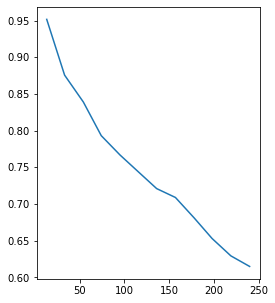

In [67]:
plt.figure(figsize=(4,5))
event_probs.mean().plot.line()

In [53]:
# to easily plot confidence intervals
def plot_ci(mean, upper_ci, lower_ci, i=30, title='Probability of survival $P(T \geq t)$'):

    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

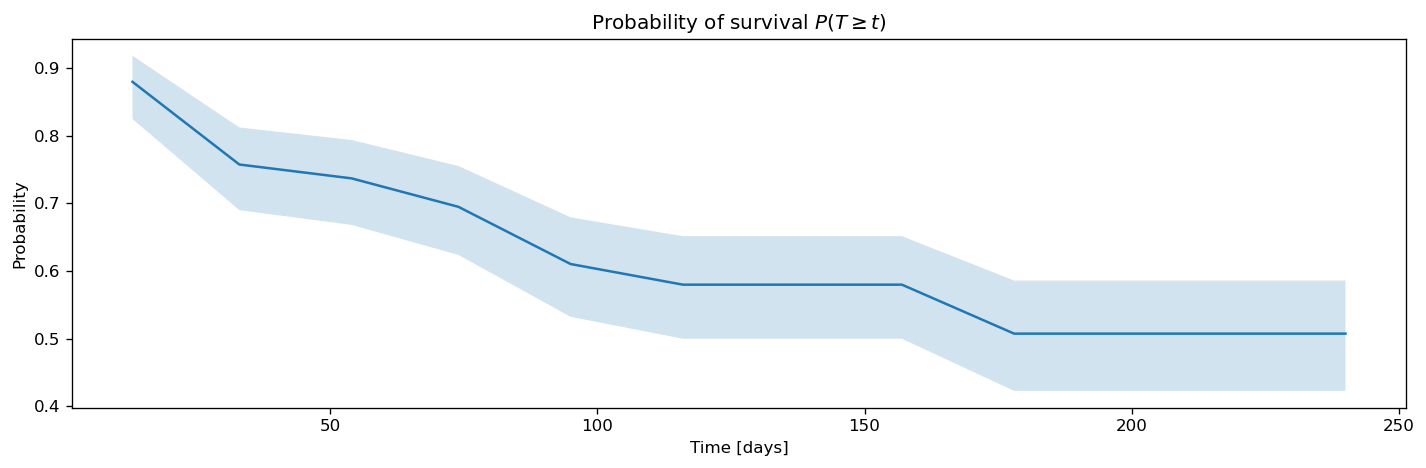

In [27]:
# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X, return_ci=True)
# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

### Real Analysis splitting into train/test split

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

In [34]:
# splitting between train, and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

In [35]:
from xgbse import XGBSEKaplanTree, XGBSEBootstrapEstimator
from xgbse.metrics import concordance_index, approx_brier_score
# xgboost parameters to fit our model
PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster':'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0
}

In [36]:
# fitting xgbse model
xgbse_model = XGBSEKaplanTree(PARAMS_TREE)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

XGBSEKaplanTree(xgb_params={'booster': 'dart', 'colsample_bynode': 1.0,
                            'eval_metric': 'cox-nloglik', 'max_depth': 10,
                            'min_child_weight': 50, 'objective': 'survival:cox',
                            'subsample': 1.0, 'tree_method': 'hist'})

##### The KaplanTree and KaplanNeighbors models support estimation of confidence intervals via the Exponential Greenwood formula.

In [37]:
# predicting
mean, upper_ci, lower_ci = xgbse_model.predict(X_test, return_ci=True)

In [39]:
# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

C-index: 0.5
Avg. Brier Score: 0.16379075767673226


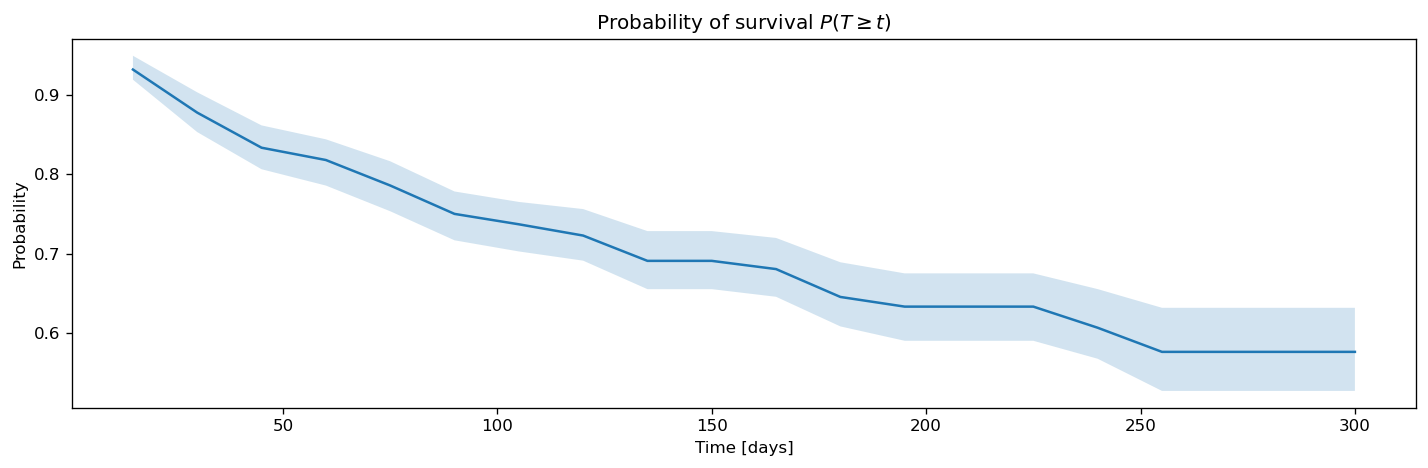

In [51]:
# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

### Non-parametric Form
##### -XGBSEBootstrapEstimator Model 
###### To wrap any XGBSE model and get confidence intervals via bagging
###### which also increase performance at the cost of computation time

In [43]:
# base model as XGBSEKaplanTree
base_model = XGBSEKaplanTree(PARAMS_TREE)

In [44]:
# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=100)

In [45]:
# fitting the meta estimator
bootstrap_estimator.fit(X_train, y_train, time_bins=TIME_BINS)

XGBSEBootstrapEstimator(base_estimator=XGBSEKaplanTree(xgb_params={'booster': 'dart',
                                                                   'colsample_bynode': 1.0,
                                                                   'eval_metric': 'cox-nloglik',
                                                                   'max_depth': 10,
                                                                   'min_child_weight': 50,
                                                                   'objective': 'survival:cox',
                                                                   'subsample': 1.0,
                                                                   'tree_method': 'hist'}),
                        n_estimators=100)

In [46]:
# predicting
mean, upper_ci, lower_ci = bootstrap_estimator.predict(X_test, return_ci=True)

In [47]:
# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

C-index: 0.5
Avg. Brier Score: 0.16380587772018423


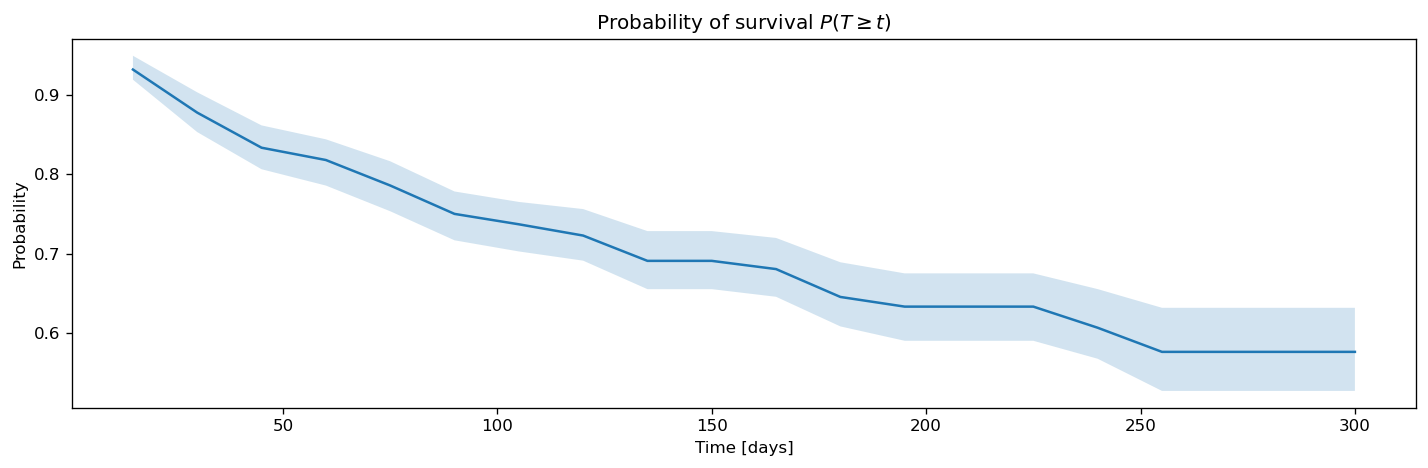

In [52]:
# plotting CIs
plot_ci(mean, upper_ci, lower_ci)

### References
https://loft-br.github.io/xgboost-survival-embeddings/basic-usage.html